## 4.4 模型选择,欠拟合,过拟合

### 4.4.1 训练误差和泛化误差

#### 1.独立同分布假设

现实中总会涉及一些违背独立同分布假设的情况,不过有些轻微违背并无影响.  
而另一些则会面临一些问题(见后文)

#### 2.模型复杂性

一个经验法则:能够轻松解释任意事实的模型是复杂的,而表达力有限但仍能很好地解释数据的模型可能更有实际用途

本节为了给出一些直观的印象，我们将重点介绍几个倾向于影响模型泛化的因素。
1. **可调整参数的数量**。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。
2. **参数采用的值**。当权重的取值范围较大时，模型可能更容易过拟合。
3. **训练样本的数量**。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

总的来说,模型越复杂,就越容易过拟合.&ensp;&ensp;很简单,因为<mark>复杂模型学习能力太强,会学到一些不该学的抽取的样本中的特殊信息</mark>

### 4.4.2 模型选择

1. 划分验证集
2. K折交叉验证

### 4.4.3 欠拟合&过拟合

- 欠拟合: 训练误差和验证误差之间只有一点差距,但是都很大  
模型不能减小训练误差,说明模型表达能力不足
- 过拟合: 训练误差明显小于验证误差  
过拟合并不总是一件坏事,因为我们关注的是验证误差

过拟合和欠拟合主要取决于模型复杂性和训练数据集的大小
#### 1.模型复杂性

对单个特征x和对应标签y组成的数据集, 以线性模型为例,多项式阶数越高,模型越复杂,也越容易过拟合.  
事实上,函数阶数等于数据样本数的多项式函数可以完美拟合数据集 [~~有机会了尝试实现一下~~|书中后文就是]

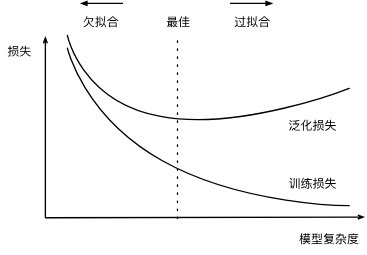

#### 2.数据集大小

- 训练数据集中的样本数越小,越可能(而且更严重地)过拟合
- 随训练数据量的增加,泛化误差通常会减少
- 对于固定的任务和数据分布,模型复杂度和数据集大小之间通常存在一定的关系:
    - 对更大的数据集, 我们就可能尝试拟合一个更复杂的模型
    - 如果没有足够的数据量,简单的模型可能更有用

### 4.4.4 多项式回归

我们可以通过多项式拟合来探索这些概念

<mark>**原理**</mark>  
线性回归：$y = w₁x + w₀$  
多项式回归（3次多项式）：$y = w₃x³ + w₂x² + w₁x + w₀$

多项式回归可以重写为:  
令：$z₁ = x, z₂ = x², z₃ = x³, z₄ = 1$  
则：$y = w₃z₃ + w₂z₂ + w₁z₁ + w₀z₄$  
即**输入特征为高次的线性回归**

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

#### 1.生成数据集

给定x,我们使用以下三阶多项式来生成数据:$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2).$$
这里将平常的多项式中的$x^i$ 调整为$\frac{x^i}{i!}$,是因为在优化过程中我们通常希望避免非常大的数(梯度/损失值)

In [114]:
#为训练集和测试集各生成100个样本
rng=np.random.default_rng(3)

max_degree=20 #max degree
n_train,n_test=100,100 #size of train data and test data
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=rng.normal(size=(n_train+n_test,1))
rng.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))  # return 200*20
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)  #gamma(i+1)=i!

labels=np.dot(poly_features,true_w)  #200*20 @ 20 -->200
labels+=rng.normal(scale=0.1,size=labels.shape)

In [115]:
#NumPyndarray-->tensor
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32)
                                      for x in [true_w,features,poly_features,labels]]


In [116]:
labels.shape

torch.Size([200])

In [117]:
features[:2],poly_features[:2],labels[:2]

(tensor([[ 0.1342],
         [-0.9259]]),
 tensor([[ 1.0000e+00,  1.3424e-01,  9.0102e-03,  4.0318e-04,  1.3531e-05,
           3.6327e-07,  8.1275e-09,  1.5586e-10,  2.6154e-12,  3.9010e-14,
           5.2367e-16,  6.3906e-18,  7.1490e-20,  7.3821e-22,  7.0784e-24,
           6.3347e-26,  5.3148e-28,  4.1968e-30,  3.1299e-32,  2.2114e-34],
         [ 1.0000e+00, -9.2590e-01,  4.2865e-01, -1.3229e-01,  3.0623e-02,
          -5.6707e-03,  8.7509e-04, -1.1575e-04,  1.3396e-05, -1.3782e-06,
           1.2761e-07, -1.0741e-08,  8.2876e-10, -5.9027e-11,  3.9038e-12,
          -2.4097e-13,  1.3944e-14, -7.5948e-16,  3.9067e-17, -1.9038e-18]]),
 tensor([5.2813, 1.6257]))

#### 2.对模型进行训练和测试

In [1]:
#evaluate loss
def evaluate_loss(net,data_iter,loss):
    '''
    use "loss" to evaluate the loss of the module
    '''
    metric=d2l.Accumulator(2) #用于计算指定数量的变量的累计和
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel()) #torch.numel()获取输入张量内的元素个数
    return metric[0]/metric[1]
    

In [124]:
# define function of train
def train(train_features,test_features,train_labels,test_labels,num_epochs=500):
    loss=nn.MSELoss(reduction='none')
    input_shape=train_features.shape[-1]
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False)) #多项式函数中已经包括了偏置
    
    batch_size=min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size) ##
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)

    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                          xlim=[1,num_epochs],ylim=[1e-3,1e2],
                          legend=['train','test'])

    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

----
```python
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.

    Defined in :numref:`sec_utils`"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)
```
- 函数内部首先使用`torch.utils.data.TensorDataset`来创建一个数据集（dataset），它接收多个张量作为参数，并假设这些张量第一个维度是样本维度.  
*这里通过`*data_arrays`拆包传入多个张量*  
- 然后，使用`torch.utils.data.DataLoader`来创建一个数据加载器（data loader），它负责从数据集中按批次加载数据，并可以设置是否打乱数据。
    - 训练阶段: is_train=True，数据会被打乱
    - 验证/测试阶段: is_train=False，数据保持原顺序
---- 

#### 3.三阶多项式函数拟合(正常)

weight: [[ 5.0080347  1.2045202 -3.3846407  5.6102524]]


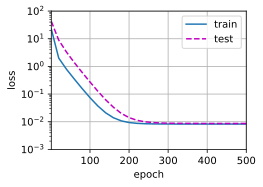

In [121]:
#choose the first four dimensions
train(poly_features[:n_train,:4],poly_features[n_test:,:4],
      labels[:n_train],labels[n_test:])

结果很接近真实值`[5,1.2,-3.4,5.6]`

#### 4.线性函数拟合(欠拟合)

weight: [[3.7510176 3.5236855]]


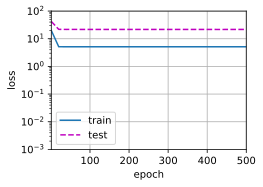

In [122]:
#just choose the first two dimentions
train(poly_features[:n_train,:2],poly_features[n_test:,:2],
      labels[:n_train],labels[n_test:])

可以看到损失始终很大,降不下去.

#### 5.高阶多项式函数(过拟合)

weight: [[ 4.9931903   1.3244957  -3.2716374   5.0740175  -0.4479785   1.2374517
   0.09091494  0.37271068  0.29100993 -0.1894829  -0.06473251  0.18881345]]


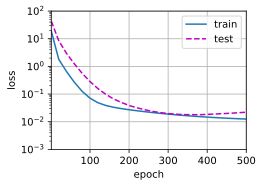

In [123]:
train(poly_features[:n_train,:12],poly_features[n_test:,:12],
      labels[:n_train],labels[n_test:])

weight: [[ 4.9878459e+00  1.3360277e+00 -3.2400084e+00  4.9916463e+00
  -5.3740340e-01  1.5529000e+00 -1.5825672e-02  3.7569669e-01
  -3.4879774e-02 -1.5075113e-01  1.4264286e-01 -2.4808228e-02
  -1.2184107e-01 -1.6939607e-01 -1.3473447e-01  8.3885849e-02
  -5.7705689e-02  1.6800394e-02  3.3886808e-03 -1.4214891e-01]]


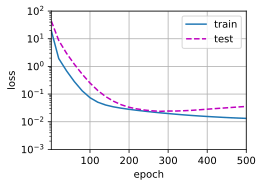

In [120]:
train(poly_features[:n_train,:],poly_features[n_test:,:],
      labels[:n_train],labels[n_test:])

----
<div style="background: #f6dcce; border-left: 5px solid #ed5126; padding: 10px; margin: 10px 0;">
<strong>ATTENTION</strong><br>
注:<br>
1. 具体的train和test的loss的<strong>绝对接近程度</strong>(即图像上这两条线之间的距离) 受第一步生成数据的随机情况影响很大<br>
2. 有时候test的loss不会上升,而这里找到了一组仅12阶就发生test上升的数据<br>
3. 训练轮数多了过拟合概率很大
</div>
